# **Algorithm and Data Mining for Data Science Homework 2**



## **#2 Homework: Instagram Profiles & Posts**

## **[RQ1] Data Analysis (EDA)**

In [104]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
posts = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t", iterator=True, chunksize = 1000)
locations = pd.read_csv('../Datasets/instagram_locations.csv', sep='\t', iterator=True, chunksize = 100)
profiles = pd.read_csv('../Datasets/instagram_profiles.csv', sep='\t', iterator=True, chunksize = 100)
num_chunks = 10000

In [4]:
posts_chunk = posts.get_chunk(num_chunks)
locations_chunk = locations.get_chunk(num_chunks)
profiles_chunk = profiles.get_chunk(num_chunks)

In [ ]:
posts.get_chunk(5)

In [ ]:
posts_chunk.info()

In [ ]:
locations.get_chunk(5)

In [ ]:
locations_chunk.info()

In [ ]:
profiles.get_chunk(5)

In [ ]:
profiles_chunk.info()

In [ ]:

num_post_ids, num_loc_cities, num_profiles_names = posts_chunk['post_id'].nunique(), locations_chunk['city'].nunique(), profiles_chunk['profile_name'].nunique()

print("Unique post IDs: {}".format(num_post_ids))
print("Unique location cities: {}".format(num_loc_cities))
print("Unique profile names: {}".format(num_profiles_names))

## **[RQ2] Simple Insights**

In [ ]:
# Plot the number of posts for each profile in descending order
profiles_chunk.groupby(["profile_id"], dropna=True)['n_posts'].sum()
profiles_chunk.sort_values(by='n_posts', ascending = False)

In [ ]:
# What posts have the highest number of "likes"?
posts_chunk.sort_values(by='numbr_likes', ascending=False).head(10)

In [ ]:
# What posts have the most and the least number of comments?
most_comments = posts_chunk.sort_values(by='number_comments', ascending=False).head(10)
least_comments = posts_chunk.sort_values(by=['number_comments', 'numbr_likes'], ascending=[True, True]).head(10)
pd.concat([most_comments,least_comments], axis = 0)

In [ ]:
# How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.
no_location = posts_chunk['location_id'].isna().sum()
tagged_location = posts_chunk['location_id'].count()

In [ ]:
df = pd.DataFrame({'posts': [no_location, tagged_location],
                  'index': ['No Location', 'Tagged Location']})

plot = df.plot.bar(x='index', y='posts', rot=0)

In [ ]:
# How many posts include only photos? How many also have videos?
only_photos = posts_chunk.loc[posts_chunk['post_type'] == 1, 'post_type'].sum()
video_multi = posts_chunk.loc[posts_chunk['post_type'] > 1, 'post_type'].sum()

In [ ]:
df = pd.DataFrame({'posts': [only_photos, video_multi],
                   'index': ['Post type: Photo', 'Post type: Video or Multi']})

plot = df.plot.bar(x='index', y='posts', rot=0)

In [ ]:
# What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

business, not_business = profiles_chunk['is_business_account'].value_counts()
not_business += profiles_chunk['is_business_account'].isnull().sum()
print("business account percentage: {}\nnot business account percentage: {}".format((business/profiles_chunk['is_business_account'].size) * 100 , (not_business/profiles_chunk['is_business_account'].size) * 100))

## **[RQ3] Now it's important to understand the most common times in which users publish their posts**

In [ ]:
# What is the most common time in which users publish their posts?
import datetime

profiles_chunk['times'] = pd.to_datetime(profiles_chunk['cts']).dt.strftime('%H:%M:%S')
profiles_chunk.groupby(['times'])['times'].count().reset_index(name='number_posts_submitted').sort_values(['number_posts_submitted'], ascending=False)

In [ ]:
# Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

def plot_posts_per_time(interval_list):
    cts = profiles_chunk.groupby(['times'])['times'].count().reset_index(name='number_posts_submitted').sort_values(['number_posts_submitted'], ascending=False)
    cts['times'] = pd.to_datetime(cts['times'], format='%H:%M:%S').dt.time
    times = list(zip(cts.times, cts.number_posts_submitted))
    default_value = 0
    keys = []
    for initial_time, end_time in interval_list:
        keys.append(initial_time + '-' + end_time)
    posts_in_intervals = dict.fromkeys(keys,default_value)
    for initial_time, end_time in interval_list:
        for time, num_post in times:
            if pd.to_datetime(initial_time).time() <= time <= pd.to_datetime(end_time).time():
                posts_in_intervals[initial_time + '-' + end_time] += num_post

    fig, ax = plt.subplots()
    ax.barh(*zip(*posts_in_intervals.items()))
    plt.show()

In [ ]:
# Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

interval_list = [('06:00:00', '10:59:59'),('11:00:00', '13:59:59'), ('14:00:00', '16:59:59'), ('17:00:00', '19:59:59'), ('20:00:00', '23:59:59'), ('00:00:00', '02:59:59'), ('03:00:00','05:59:59')]

plot_posts_per_time(interval_list)

## **[RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.**

In [ ]:
# Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.
def get_posts_by_profile_id(profile_id):
    return posts_chunk.query("profile_id == {}".format(profile_id))

get_posts_by_profile_id(260162660)

In [ ]:
# Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

def post_of_n_top_posted_profiles(n):
    profiles_chunk.groupby(["profile_id"], dropna=True)['n_posts'].sum()
    n_top_profiles = profiles_chunk.sort_values(by='n_posts', ascending = False).head(n)
    filter_list = n_top_profiles['profile_id']
    return posts_chunk[posts_chunk['profile_id'].isin(filter_list)]

In [ ]:
# What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

posts_of_n_top_profiles = post_of_n_top_posted_profiles(10)
print("Average number of likes: {}\nAverage number of comments: {}".format(posts_of_n_top_profiles['numbr_likes'].mean(), posts_of_n_top_profiles['number_comments'].mean()))

In [ ]:
# Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.

In [82]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
posts = pd.read_csv('../Datasets/instagram_posts.csv', sep="\t", iterator=True, chunksize = 1000)
locations = pd.read_csv('../Datasets/instagram_locations.csv', sep='\t', iterator=True, chunksize = 100)
profiles = pd.read_csv('../Datasets/instagram_profiles.csv', sep='\t', iterator=True, chunksize = 100)
num_chunks = 10000

In [4]:
posts_chunk = posts.get_chunk(num_chunks)
locations_chunk = locations.get_chunk(num_chunks)
profiles_chunk = profiles.get_chunk(num_chunks)

In [4]:
posts.get_chunk(5)

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
10000,28381208,-1,BpPPJe6FnO3,8135621357,173399483337248,2018-10-22 16:04:23.000,1,"Velkommen til Verksted Jord, vi har åpent tors...",37,0
10001,28381168,-1,BtoKk2Jlszk,3117914696,316620195072788,2019-02-08 17:31:01.000,1,"I get to paint this beautiful hair tomorrow, I...",59,1
10002,28381166,-1,Bt-Fml-g4Vj,3117914696,316620195072788,2019-02-17 05:50:51.000,1,🎨✨Another one for @oneshothairawards #btconesh...,30,0
10003,28381167,-1,BtsDooElK-x,3117914696,316620195072788,2019-02-10 05:47:20.000,1,Just a little taste of something new coming fr...,80,2
10004,28381165,-1,Bt_15oDgPNL,3117914696,316620195072788,2019-02-17 22:12:07.000,1,Cool Balayage 🌪 @oneshothairawards #btconeshot...,43,1


In [5]:
posts_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sid              10000 non-null  int64 
 1   sid_profile      10000 non-null  int64 
 2   post_id          10000 non-null  object
 3   profile_id       10000 non-null  int64 
 4   location_id      10000 non-null  int64 
 5   cts              10000 non-null  object
 6   post_type        10000 non-null  int64 
 7   description      9228 non-null   object
 8   numbr_likes      10000 non-null  int64 
 9   number_comments  10000 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 781.4+ KB


In [6]:
locations.get_chunk(5)

,sid,id,name,street,zip,city,region,cd,phone,aj_exact_city_match,...,dir_city_name,dir_city_slug,dir_country_id,dir_country_name,lat,lng,primary_alias_on_fb,slug,website,cts
10000,729105,254897701743394,Tita Cecilia,621 W Carson St,90745,"Carson, California",NaN,US,(424) 731-7218,False,...,West Carson,west-carson,US,United States,-118.286770,33.831880,NaN,tita-cecilia,http://www.farmersagent.com/,2019-05-29 10:30:41.784
10001,729107,113829812660344,Balneario Buenos Aires Maldonado,NaN,NaN,"Barra De Maldonado, Maldonado, Uruguay",NaN,UY,NaN,False,...,Barra de Maldonado,barra-de-maldonado,UY,Uruguay,-54.800241,-34.885643,NaN,balneario-buenos-aires-maldonado,NaN,2019-05-29 10:30:48.639
10002,729109,39247447,Hotel Imperial,Maršala Tita 124/3,51410,Abbazia,NaN,HR,+385(51)710444,False,...,NaN,NaN,NaN,NaN,14.305749,45.334341,NaN,hotel-imperial,http://www.remisens.com/en/hotel-imperial,2019-05-29 10:30:55.160
10003,729082,2309122105768753,Cafe u Najády,Dr. Veselého 178,763 26,Luhacovice,NaN,CZ,+420608908777,False,...,Luhacovice,luhacovice,CZ,Czech Republic,17.759249,49.105132,NaN,cafe-u-najady,NaN,2019-05-29 10:29:20.423
10004,729088,884397744992253,Karya Binayak Temple,Suryabinayak,NaN,"Bungmati, Nepal",NaN,NP,9841176079,False,...,NaN,NaN,NaN,NaN,85.302375,27.631869,NaN,karya-binayak-temple,NaN,2019-05-29 10:29:41.831


In [7]:
locations_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sid                     10000 non-null  int64  
 1   id                      10000 non-null  int64  
 2   name                    10000 non-null  object 
 3   street                  6859 non-null   object 
 4   zip                     6690 non-null   object 
 5   city                    9057 non-null   object 
 6   region                  5 non-null      object 
 7   cd                      9062 non-null   object 
 8   phone                   5664 non-null   object 
 9   aj_exact_city_match     9749 non-null   object 
 10  aj_exact_country_match  9749 non-null   object 
 11  blurb                   3793 non-null   object 
 12  dir_city_id             4767 non-null   object 
 13  dir_city_name           4767 non-null   object 
 14  dir_city_slug           4759 non-null  

In [8]:
profiles.get_chunk(5)

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
10000,4195504,416365428,shytown1972,esteban toledo,NaN,NaN,NaN,NaN,NaN,2019-08-02 03:09:32.567 -0400,NaN
10001,4195507,11586554930,nc_thoughts,NC Thoughts,Art 🖼 Poetry 💋 Photography 📸 \nInvisible illne...,296.0,59.0,35.0,www.redbubble.com/people/ncthoughts?ref=more_w...,2019-08-02 03:09:39.203 -0400,True
10002,4195508,3190180070,soflobeachblog,SoFlo Girl,Im just a New England girl who fell in love w/...,4241.0,2411.0,670.0,NaN,2019-08-02 03:09:56.635 -0400,False
10003,4195513,372838856,mikeroma79,Mike | Real Estate | Fitness,Arte Surfside/Corcoran Sunshine/Lic Sales Asso...,662.0,11766.0,285.0,fnx.grsm.io/mikeroma79,2019-08-02 03:10:17.542 -0400,False
10004,4195515,17486517,beardgang,BEARDGANG,NaN,NaN,NaN,NaN,NaN,2019-08-02 03:10:32.345 -0400,NaN


In [9]:
profiles_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sid                  10000 non-null  int64  
 1   profile_id           10000 non-null  int64  
 2   profile_name         10000 non-null  object 
 3   firstname_lastname   9571 non-null   object 
 4   description          5096 non-null   object 
 5   following            6379 non-null   float64
 6   followers            6379 non-null   float64
 7   n_posts              6379 non-null   float64
 8   url                  2325 non-null   object 
 9   cts                  9999 non-null   object 
 10  is_business_account  6379 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 859.5+ KB


In [10]:

num_post_ids, num_loc_cities, num_profiles_names = posts_chunk['post_id'].nunique(), locations_chunk['city'].nunique(), profiles_chunk['profile_name'].nunique()

print("Unique post IDs: {}".format(num_post_ids))
print("Unique location cities: {}".format(num_loc_cities))
print("Unique profile names: {}".format(num_profiles_names))

Unique post IDs: 10000
Unique location cities: 4856
Unique profile names: 10000


## **[RQ2] Simple Insights**

In [36]:
# Plot the number of posts for each profile in descending order
profiles_chunk.groupby(["profile_id"], dropna=True)['n_posts'].sum()
profiles_chunk.sort_values(by='n_posts', ascending = False)

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
6957,4192500,243048679,fawaz4422,Fawaz Abdullah Al Jaidah,🇬🇧. @Fawazabdullah.🇬🇧 @hani_almawash - @w3c5 -...,6755.0,9976.0,37753.0,NaN,2019-08-01 23:13:49.919 -0400,True
3256,4188835,978311336,djpeanutwao,Raul Alberto Marin Ayarza,"Locutor en Wao971/2, Dj y animador profesional...",3022.0,20033.0,14271.0,www.sal-mar.com,2019-08-01 18:41:00.467 -0400,False
1424,4185860,7488360111,maciej.rekosiewicz,Maciej Rękosiewicz,"Udaję że piszę, udaję że fotografuję, udaję że...",1342.0,18526.0,13831.0,NaN,2019-08-01 16:21:07.098 -0400,False
6245,4191788,1345225405,sriutari_,Utarishopbali,"Fasion Wantia&Pria, Pakian Adat Bali, BataM, D...",7504.0,2626.0,12677.0,m.facebook.com/sriutari.cute?fref=nf,2019-08-01 22:18:22.884 -0400,False
6416,4191982,1707976050,elf_qadin_dunyasi,ELF ❤ Qadin Dunyasi,📲☎️whatsApp 050 884 0999🇦🇿🇦🇿🇦🇿 Dunyaca meshur ...,787.0,23123.0,11899.0,NaN,2019-08-01 22:34:50.509 -0400,True
...,...,...,...,...,...,...,...,...,...,...,...
9982,4195473,8371589679,shotoniphoneseries,Shot On iPhone Series,NaN,NaN,NaN,NaN,NaN,2019-08-02 03:06:49.301 -0400,NaN
9985,4195482,271762435,ilsanders89,Imogen Litan Sanders,NaN,NaN,NaN,NaN,NaN,2019-08-02 03:07:29.675 -0400,NaN
9987,4195486,1965945621,grantabooks,Granta Books,NaN,NaN,NaN,NaN,NaN,2019-08-02 03:07:49.425 -0400,NaN
9995,4195511,2875637492,mrslucyevans,Lucy Evans,NaN,NaN,NaN,NaN,NaN,2019-08-02 03:10:11.714 -0400,NaN


In [12]:
# What posts have the highest number of "likes"?
posts_chunk.sort_values(by='numbr_likes', ascending=False).head(10)

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
1861,28372824,3444658,BWatkdZACtC,7061024,59743640,2017-07-11 21:05:22.000,1,Я вот просматриваю иногда свой аккаунт Инстагр...,298913,386
1265,26702072,301272,BP3clgjDC-Q,319897212,1029929202,2017-01-30 00:15:11.000,1,Iridescent pastel pink 🦄 \nCreated using Lipgl...,129571,386
2660,28374117,548786,Bvo_FBVgypy,208502444,751708427,2019-03-30 18:12:35.000,1,Confirmation that Huddersfield are relegated f...,123678,484
5471,28376593,-1,BJs2p4ZBYn3,335410451,568572977,2016-08-29 19:22:57.000,1,On rigole bien quand même💃🏼,106113,545
5805,28376800,-1,BaWZhdrnL2n,530835252,274141210,2017-10-17 14:58:48.000,1,Algún día debería hacer una quedada 🤤🤤\nCuando...,67342,398
4786,28375819,-1,BxDZBh-nMLT,3127385206,347539836,2019-05-04 21:50:56.000,1,"Prévias feitas! Agora é comer, descansar e esp...",60736,879
4489,28375502,96176,BWV0XlLFYap,28226901,56495,2017-07-09 23:28:34.000,1,Baby Driver in Wellington (📸 @carmelovarela),50442,116
7633,28378626,355000,BeoMTEvAPHr,43867292,229414338,2018-01-31 21:55:09.000,1,Great morning at Spence. Many thanks Hollie @h...,47271,152
7115,28378115,-1,BvQHvOHBOab,1526791424,1018609727,2019-03-21 02:27:14.000,1,Măm Măm 😋😋😋 #ngoctrinh #ngoctrinhofficial #you...,47065,171
1407,28372402,3267216,BMZ1dkwAFSH,26017486,5096215,2016-11-04 22:41:09.000,1,date night at putte's 🍕#helsinkisecret,43821,53


In [13]:
# What posts have the most and the least number of comments?
most_comments = posts_chunk.sort_values(by='number_comments', ascending=False).head(10)
least_comments = posts_chunk.sort_values(by=['number_comments', 'numbr_likes'], ascending=[True, True]).head(10)
pd.concat([most_comments,least_comments], axis = 0)

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
5633,27386281,3398819,BgkKMt4hAW7,2955286544,1012854533,2018-03-21 01:22:38.000,1,"Доброе утро, красотки 💃🏻\nУ нас отличная новос...",302,13983
3319,28374324,396283,BfrIDlygv1G,217723373,548438207,2018-02-26 21:47:12.000,1,"Despite a steady downpour, thousands flocked t...",23425,1340
9733,28380873,-1,BxCwkRuAKgi,238711109,2229985840579401,2019-05-04 15:57:25.000,1,🎉🎉GIVEAWAY🎉🎉\n.\n@yifangtea.sg has launched th...,641,1012
4786,28375819,-1,BxDZBh-nMLT,3127385206,347539836,2019-05-04 21:50:56.000,1,"Prévias feitas! Agora é comer, descansar e esp...",60736,879
2659,25528599,-1,BtB0CP-nAIc,373344088,751708427,2019-01-24 20:02:55.000,1,I'm really happy for the opportunity to play i...,24232,792
4417,28375403,87675,BxuReBznXnw,7629888318,127562401356728,2019-05-21 13:32:16.000,1,🍦🍨🍦Ice cream giveaway!!🍦🍨🍦\nTo kick off summer...,432,642
5471,28376593,-1,BJs2p4ZBYn3,335410451,568572977,2016-08-29 19:22:57.000,1,On rigole bien quand même💃🏼,106113,545
2660,28374117,548786,Bvo_FBVgypy,208502444,751708427,2019-03-30 18:12:35.000,1,Confirmation that Huddersfield are relegated f...,123678,484
567,28371656,-1,BfymkS7nVN8,20935109,264423834,2018-03-01 19:28:30.000,1,"NAME MY SHOW!!!Awhile back, I asked you guys w...",20848,467
5805,28376800,-1,BaWZhdrnL2n,530835252,274141210,2017-10-17 14:58:48.000,1,Algún día debería hacer una quedada 🤤🤤\nCuando...,67342,398


In [14]:
# How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results.
no_location = posts_chunk['location_id'].isna().sum()
tagged_location = posts_chunk['location_id'].count()

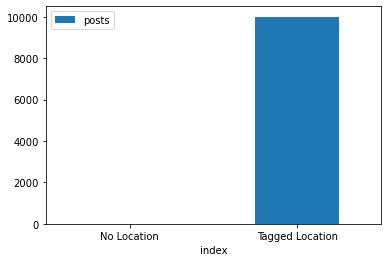

In [15]:
df = pd.DataFrame({'posts': [no_location, tagged_location],
                  'index': ['No Location', 'Tagged Location']})

plot = df.plot.bar(x='index', y='posts', rot=0)

In [21]:
# How many posts include only photos? How many also have videos?
only_photos = posts_chunk.loc[posts_chunk['post_type'] == 1, 'post_type'].sum()
video_multi = posts_chunk.loc[posts_chunk['post_type'] > 1, 'post_type'].sum()

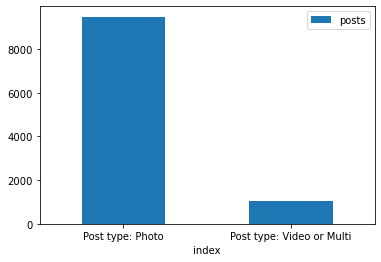

In [22]:
df = pd.DataFrame({'posts': [only_photos, video_multi],
                   'index': ['Post type: Photo', 'Post type: Video or Multi']})

plot = df.plot.bar(x='index', y='posts', rot=0)

In [55]:
# What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

business, not_business = profiles_chunk['is_business_account'].value_counts()
not_business += profiles_chunk['is_business_account'].isnull().sum()
print("business account percentage: {}\nnot business account percentage: {}".format((business/profiles_chunk['is_business_account'].size) * 100 , (not_business/profiles_chunk['is_business_account'].size) * 100))

business account percentage: 37.15
not business account percentage: 62.849999999999994


## **[RQ3] Now it's important to understand the most common times in which users publish their posts**

In [40]:
# What is the most common time in which users publish their posts?
import datetime

profiles_chunk['times'] = pd.to_datetime(posts_chunk['cts']).dt.strftime('%H:%M:%S')
profiles_chunk.groupby(['times'])['times'].count().reset_index(name='number_posts_submitted').sort_values(['number_posts_submitted'], ascending=False)

,times,number_posts_submitted
7444,19:47:56,3
4846,14:53:01,3
5490,16:06:57,3
4610,14:24:03,3
51,00:08:18,3
...,...,...
3195,10:52:35,1
3194,10:52:19,1
3193,10:52:09,1
3192,10:52:00,1


In [41]:
# Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

def plot_posts_per_time(interval_list, input):
    if input is not None:
        dataset = input
    else: dataset = profiles_chunk
    cts = dataset.groupby(['times'])['times'].count().reset_index(name='number_posts_submitted').sort_values(['number_posts_submitted'], ascending=False)
    cts['times'] = pd.to_datetime(cts['times'], format='%H:%M:%S').dt.time
    times = list(zip(cts.times, cts.number_posts_submitted))
    default_value = 0
    keys = []
    for initial_time, end_time in interval_list:
        keys.append(initial_time + '-' + end_time)
    posts_in_intervals = dict.fromkeys(keys,default_value)
    for initial_time, end_time in interval_list:
        for time, num_post in times:
            if pd.to_datetime(initial_time).time() <= time <= pd.to_datetime(end_time).time():
                posts_in_intervals[initial_time + '-' + end_time] += num_post

    fig, ax = plt.subplots()
    ax.barh(*zip(*posts_in_intervals.items()))
    plt.show()

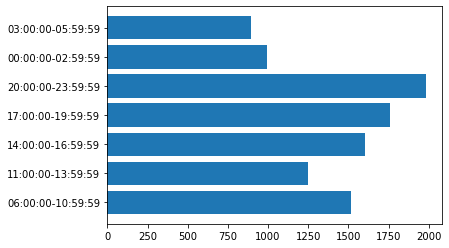

In [42]:
# Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

interval_list = [('06:00:00', '10:59:59'),('11:00:00', '13:59:59'), ('14:00:00', '16:59:59'), ('17:00:00', '19:59:59'), ('20:00:00', '23:59:59'), ('00:00:00', '02:59:59'), ('03:00:00','05:59:59')]

plot_posts_per_time(interval_list, None)

## **[RQ4] In most cases, we will not have a consistent dataset, and the one we are dealing with is not an exception (ex. in the given datasets, you may not find the information of the profiles for some of the posts). So let’s enhance our analysis.**

In [43]:
# Write a function that, given a profile_id, will be able to return the posts that belong to the given profile_id.
def get_posts_by_profile_id(profile_id):
    return posts_chunk.query("profile_id == {}".format(profile_id))

get_posts_by_profile_id(260162660)

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
980,28371980,-1,BgL2hudDhs6,260162660,527503834011860,2018-03-11 14:48:58.000,1,Some people want understand this picture but i...,18,0
981,28371989,-1,Bx1hPfRgoEf,260162660,527503834011860,2019-05-24 09:04:47.000,1,At 3 in da morning it’s a damn shame but this ...,1,0
982,28371988,-1,BxnS_a4jTt8,260162660,527503834011860,2019-05-18 20:30:53.000,1,Chilling with the rude boy Campbell I gotta sh...,11,0
983,28371983,-1,BxlUigzA_td,260162660,527503834011860,2019-05-18 02:05:56.000,1,The grind don’t stop there’s no event to big o...,14,2
984,28371992,-1,BxhhYC-AAef,260162660,527503834011860,2019-05-16 14:41:08.000,1,Gm world from my nep dj mir with his Kodak pose,4,0
985,28371993,-1,BxgZIPDgEfi,260162660,527503834011860,2019-05-16 04:09:50.000,1,I’m this old Lmmfao my favorite cartoon,4,0
986,28371974,-1,Bxe3LdiACNN,260162660,527503834011860,2019-05-15 13:54:26.000,2,Book me for your next event,31,1
987,28371994,-1,BxBPC7rgts-,260162660,527503834011860,2019-05-04 01:45:16.000,1,#firstfriday ready @hb_bigmurda and @mpapeewee...,10,0
988,28371995,-1,Bw3YQJeAvic,260162660,527503834011860,2019-04-30 05:56:05.000,2,My new look treat yourself not cheat yourself ...,0,0
989,28371987,-1,BvkoDxUAqeo,260162660,527503834011860,2019-03-29 01:34:28.000,1,Long live Zaro MBF We All We Got @darealmbf,11,2


In [44]:
# Write another function that, given an input n (an integer), will return the posts that belong to the n top posted profiles (top n profiles that have posted the highest number of posts) that their data is available in the profile.csv using the previously written function.

def post_of_n_top_posted_profiles(n):
    profiles_chunk.groupby(["profile_id"], dropna=True)['n_posts'].sum()
    n_top_profiles = profiles_chunk.sort_values(by='n_posts', ascending = False).head(n)
    filter_list = n_top_profiles['profile_id']
    return posts_chunk[posts_chunk['profile_id'].isin(filter_list)]

In [45]:
# What is the average number of "likes" and comments of the top 10 profiles with the highest number of posts which their information is available in profile.csv?

posts_of_n_top_profiles = post_of_n_top_posted_profiles(10)
print("Average number of likes: {}\nAverage number of comments: {}".format(posts_of_n_top_profiles['numbr_likes'].mean(), posts_of_n_top_profiles['number_comments'].mean()))

Average number of likes: nan
Average number of comments: nan


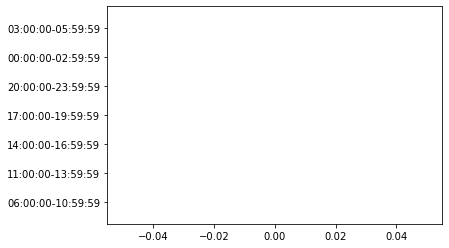

In [46]:
# Plot the number of posts that these top 10 profiles have sent on Instagram in the given interval in question RQ3. Interpret the resulting chart.
posts_of_n_top_profiles = post_of_n_top_posted_profiles(10)
posts_of_n_top_profiles['times'] = pd.to_datetime(posts_of_n_top_profiles['cts']).dt.strftime('%H:%M:%S')
posts_of_n_top_profiles.groupby(['times'])['times'].count().reset_index(name='number_posts_submitted').sort_values(['number_posts_submitted'], ascending=False)

plot_posts_per_time(interval_list, posts_of_n_top_profiles)

## **[RQ5] The most influential users are the ones with the highest number of “followers", you can now look more into their activity.**

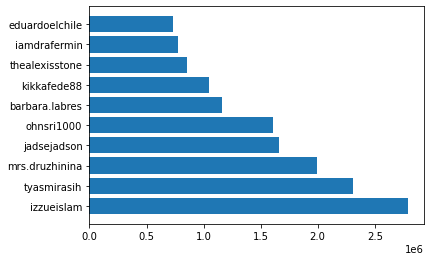

In [47]:
# Plot the top 10 most popular users in terms of followers and their number of posts.
top_ten_most_popular_profiles = profiles_chunk.sort_values(['followers'], ascending=False).head(10)
fig, ax = plt.subplots()
ax.barh(top_ten_most_popular_profiles['profile_name'], top_ten_most_popular_profiles['followers'])
plt.show()

In [62]:
# Who is the most influential user?
top_ten_most_popular_profiles.loc[top_ten_most_popular_profiles['followers'] == top_ten_most_popular_profiles['followers'].max()]

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account,times
5424,4190972,29875130,izzueislam,Izzue Islam,☎️: +60129111241 @awinnurin\n📧: iianenterprise...,179.0,2793338.0,5289.0,youtube.com/izzueislamtv,2019-08-01 21:20:58.700 -0400,False,14:45:15


In [ ]:
# Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.
posts_milion = posts.get_chunk(4000000)

In [91]:
locations = pd.read_csv('../Datasets/instagram_locations.csv', sep='\t')

In [118]:
posts_of_top_profiles = posts_milion[posts_milion['profile_id'].isin(top_ten_most_popular_profiles['profile_id'])]
posts_of_top_profiles[posts_of_top_profiles['location_id'].notnull()]
locations_count = posts_of_top_profiles.groupby(['location_id'])['location_id'].count().reset_index(name='location_count')
most_frequent_areas = locations.loc[locations['id'].isin(locations_count['location_id'])][['id','city']].rename(columns = {'id':'location_id'})

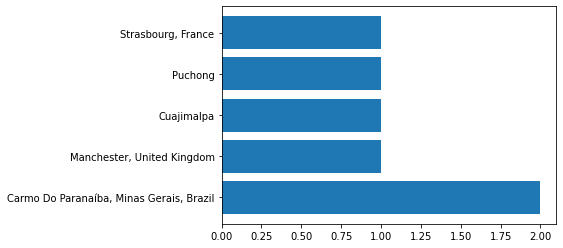

In [120]:
cities_counts = pd.merge(locations_count, most_frequent_areas, on="location_id")
fig, ax = plt.subplots()
ax.barh(cities_counts.city, cities_counts.location_count)
plt.show()

In [ ]:
# How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.

